# 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import re
from IPython.display import HTML, display
import warnings
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport
from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from plotly import express as px
import seaborn as sns
import umap.umap_ as umap

## 0.1 HELPER FUNCTIONS

In [2]:
def jupyter_settings():
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

jupyter_settings();
warnings.filterwarnings("ignore");
%matplotlib inline

## 0.2 LOADING DATA 

In [3]:
df_raw = pd.read_csv('dataset/Ecommerce.csv',encoding='mbcs')

# 1.0 DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## 1.1 DATA DIMENSIONS

In [5]:
print('Rows: {}'.format(df1.shape[0]))
print('Columns: {}'.format(df1.shape[1]))

Rows: 541909
Columns: 9


## 1.2 DATA TYPES

In [6]:
df1.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
Unnamed: 8     float64
dtype: object

In [7]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [8]:
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate']).dt.date
df1 = df1.drop('Unnamed: 8',axis=1)

In [9]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850.0,United Kingdom


## 1.3 CHECKING NA DATA

In [10]:
df1.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## 1.4 REPLACING NA 

In [11]:
df_missing = df1[df1['CustomerID'].isna()]
df_not_missing = df1[~df1['CustomerID'].isna()]
print(df_missing.shape)
print(df_not_missing.shape)

(135080, 8)
(406829, 8)


In [12]:
df_backup = pd.DataFrame(df_missing['InvoiceNo'].drop_duplicates())
df_backup['CustomerID'] = np.arange(19000,19000+len(df_backup),1)

df1 = pd.merge(df1,df_backup,on='InvoiceNo',how='left')

df1['CustomerID'] = df1['CustomerID_x'].combine_first(df1['CustomerID_y'])
df1 = df1.drop(columns=['CustomerID_x','CustomerID_y'])

In [13]:
df1.isna().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
Country           0
CustomerID        0
dtype: int64

## 1.5 CHANGING TYPE 

In [14]:
df1['CustomerID'] = df1['CustomerID'].astype(int) 

## 1.6 DESCRIPTIVE STATISTICS 

In [15]:
num_attributes = df1.select_dtypes(include=['int64','int32','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.6.1 NUMERICAL ATTRIBUTES

In [16]:
#central tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
#dispersion
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T    

#concat
table = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T
table.columns = ['min','max','range','mean','median','std','skew','kurtosis']
table

,min,max,range,mean,median,std,skew,kurtosis
Quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
UnitPrice,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
CustomerID,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.6.2 CATEGORICAL ATTRIBUTES

In [17]:
len(cat_attributes.loc[cat_attributes['InvoiceNo'].apply(lambda x: bool(re.search('[^0-9]+',str(x)))),'InvoiceNo'].drop_duplicates())

3839

In [18]:
cat_attributes.loc[cat_attributes['StockCode'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',str(x)))),'StockCode'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Invoice No

In [19]:
df_letter_invoices = df1.loc[df1['InvoiceNo'].apply(lambda x: bool(re.search('[^0-9]+',str(x)))),:]
display(len(df_letter_invoices))
display(len(df_letter_invoices[df_letter_invoices['Quantity']<0]))

9291

9288

#### Stock Code

In [20]:
df1.loc[df1['StockCode'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',str(x)))),'StockCode'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Country

In [21]:
df1['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

# 2.0 VARIABLE FILTERING

In [22]:
df2 = df1.copy()

In [23]:
#unit
df2 = df2[df2['UnitPrice']>=0.04]
#stock code
df2 = df2[~df2['StockCode'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK'])]
#description
df2 = df2.drop(columns='Description',axis=1)
#map
df2 = df2[~df2['Country'].isin(['European Community', 'Unspecified'])]
#bad users
df2 = df2[df2['CustomerID']!=16446]
#quantity
df_returns = df2[df2['Quantity']<0]
df_purchase = df2[df2['Quantity']>0]

# 3.0 FEATURE ENGINEERING

In [24]:
df3 = df2.copy()
df3_purchase = df_purchase.copy()
df3_returns = df_returns.copy()

## 3.1 FEATURE CREATION

In [25]:
df3.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,Country,CustomerID
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850


### 3.1.1 GROSS REVENUE

In [26]:
df3['GrossRevenue'] = df3['Quantity'] * df3['UnitPrice']
df_m = df3[['CustomerID','GrossRevenue']].groupby('CustomerID').sum().reset_index()
df_m.head()

,CustomerID,GrossRevenue
0,12346,0.00
1,12347,4310.00
2,12348,1437.24
3,12349,1457.55
4,12350,294.40


### 3.1.2 RECENCY: DAYS FROM LAST PURCHASE

In [27]:
df_r = df3_purchase[['CustomerID','InvoiceDate']].groupby('CustomerID').max().reset_index()
df_r['RecencyDays'] = (df3_purchase['InvoiceDate'].max()-df_r['InvoiceDate']).dt.days
df_r.drop('InvoiceDate',axis=1,inplace=True)
df_r.head()

,CustomerID,RecencyDays
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310


### 3.1.3 QUANTITY OF INVOICES

In [28]:
df_q = df3_purchase[['CustomerID','InvoiceNo']].drop_duplicates().groupby('CustomerID').count().reset_index().rename(columns={'InvoiceNo':'InvoiceQty'})
df_q.head()

,CustomerID,InvoiceQty
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1


### 3.1.4 QUANTITY OF ITEMS

In [29]:
df_qi = df3[['CustomerID','Quantity']].groupby('CustomerID').sum().reset_index().rename(columns={'Quantity':'ItemQty'})
df_qi.head()

,CustomerID,ItemQty
0,12346,0
1,12347,2458
2,12348,2332
3,12349,630
4,12350,196


### 3.1.4 QUANTITY OF PRODUCTS

In [30]:
df_qp = df3_purchase[['CustomerID','StockCode']].groupby('CustomerID').count().reset_index().rename(columns={'StockCode':'ProductQty'})
df_qp.head()

,CustomerID,ProductQty
0,12346,1
1,12347,182
2,12348,27
3,12349,72
4,12350,16


### 3.1.5 AVERAGE TICKET

In [31]:
df_at=df3[['CustomerID','GrossRevenue']].groupby('CustomerID').mean().reset_index().rename(columns={'GrossRevenue':'AvgTicket'})
df_at.head()

,CustomerID,AvgTicket
0,12346,0.000000
1,12347,23.681319
2,12348,53.231111
3,12349,20.243750
4,12350,18.400000


### 3.1.6 NUMBER OF RETURNS

In [32]:
df3_returns = df3_returns[['CustomerID','Quantity']].groupby('CustomerID').sum().reset_index().rename(columns={'Quantity':'Returns'})
df3_returns['Returns'] = df3_returns['Returns']*-1
df3_returns.head()

,CustomerID,Returns
0,12346,74215
1,12352,63
2,12359,10
3,12362,17
4,12375,1


### 3.1.7 BASKET SIZE

In [33]:
df_aux = (df3_purchase[['CustomerID','InvoiceNo','Quantity']].groupby('CustomerID')
                                                            .agg(NPurchase=('InvoiceNo','nunique'),
                                                                 NProducts=('Quantity','sum'))
                                                            .reset_index())
df_aux['BasketSize'] = df_aux['NProducts']/df_aux['NPurchase']
df_bs = df_aux[['CustomerID','BasketSize']].copy()
df_bs.head()

,CustomerID,BasketSize
0,12346,74215.000000
1,12347,351.142857
2,12348,583.000000
3,12349,630.000000
4,12350,196.000000


### 3.1.8 UNIQUE BASKET SIZE

In [34]:
df_aux = (df3_purchase[['CustomerID','InvoiceNo','StockCode']].groupby('CustomerID')
                                                              .agg(NPurchase=('InvoiceNo','nunique'),
                                                                 NProducts=('StockCode','count'))
                                                            .reset_index())
df_aux['UniqueBasketSize'] = df_aux['NProducts']/df_aux['NPurchase']
df_ubs = df_aux[['CustomerID','UniqueBasketSize']].copy()
df_ubs.head()

,CustomerID,UniqueBasketSize
0,12346,1.00
1,12347,26.00
2,12348,6.75
3,12349,72.00
4,12350,16.00


### 3.1.9 AVERAGE RECENCY DAYS

In [35]:
df_aux = df3[['CustomerID','InvoiceDate']].drop_duplicates().sort_values(['CustomerID','InvoiceDate'])
df_aux['NextCustomerID'] = df_aux['CustomerID'].shift()
df_aux['LastDate'] = df_aux['InvoiceDate'].shift()

df_aux['AvgRecencyDays'] = df_aux.apply(lambda x: (x['InvoiceDate'] - x['LastDate']).days if x['CustomerID'] == x['NextCustomerID'] else np.nan, axis=1)

df_aux = df_aux.drop(['InvoiceDate','NextCustomerID','LastDate'],axis=1).dropna()
df_rd = df_aux.groupby('CustomerID').mean().reset_index()
df_rd.head()

,CustomerID,AvgRecencyDays
0,12347,60.833333
1,12348,94.333333
2,12352,43.333333
3,12356,151.500000
4,12358,149.000000


### 3.1.10 FREQUENCY PURCHASE

In [36]:
df_aux = (df3_purchase[['CustomerID','InvoiceNo','InvoiceDate']].drop_duplicates()
                                                                .groupby('CustomerID')
                                                                .agg(max_=('InvoiceDate','max'),
                                                                     min_=('InvoiceDate','min'),
                                                                     days_=('InvoiceDate',lambda x: ((x.max()-x.min()).days) + 1),
                                                                     buy_=('InvoiceNo','count'))).reset_index()

df_aux['Frequency'] = df_aux[['buy_','days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)
df_f = df_aux[['CustomerID','Frequency']]

### 3.1.11 MERGING NEW FEATURES

In [37]:
df_ref = pd.merge(df_m,df_r,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df_q,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df_qi,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df_qp,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df_at,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df3_returns,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df_rd,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df_f,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df_bs,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df_ubs,on='CustomerID',how='left')
df_ref['Returns'] = df_ref['Returns'].fillna(value=0)
df_ref['Frequency'] = df_ref['Frequency'].fillna(value=0)
df_ref.head()

,CustomerID,GrossRevenue,RecencyDays,InvoiceQty,ItemQty,ProductQty,AvgTicket,Returns,AvgRecencyDays,Frequency,BasketSize,UniqueBasketSize
0,12346,0.00,325.0,1.0,0,1.0,0.000000,74215.0,NaN,1.000000,74215.000000,1.00
1,12347,4310.00,2.0,7.0,2458,182.0,23.681319,0.0,60.833333,0.019126,351.142857,26.00
2,12348,1437.24,75.0,4.0,2332,27.0,53.231111,0.0,94.333333,0.014085,583.000000,6.75
3,12349,1457.55,18.0,1.0,630,72.0,20.243750,0.0,NaN,1.000000,630.000000,72.00
4,12350,294.40,310.0,1.0,196,16.0,18.400000,0.0,NaN,1.000000,196.000000,16.00


In [38]:
df_ref.isna().sum()

CustomerID             0
GrossRevenue           0
RecencyDays           91
InvoiceQty            91
ItemQty                0
ProductQty            91
AvgTicket              0
Returns                0
AvgRecencyDays      2816
Frequency              0
BasketSize            91
UniqueBasketSize      91
dtype: int64

# 4.0 EXPLORATORY DATA ANALYSIS

In [39]:
df4 = df_ref.dropna()
df4 = df4.reset_index(drop=True)
df4.isna().sum()

CustomerID          0
GrossRevenue        0
RecencyDays         0
InvoiceQty          0
ItemQty             0
ProductQty          0
AvgTicket           0
Returns             0
AvgRecencyDays      0
Frequency           0
BasketSize          0
UniqueBasketSize    0
dtype: int64

### 4.1 UNIVARIATE ANALYSIS

In [40]:
profile = ProfileReport(df4)
profile.to_file('output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.2 BIVARIATE ANALYSIS

In [41]:
cols = ['CustomerID']
df42 = df4.drop(cols,axis=1)

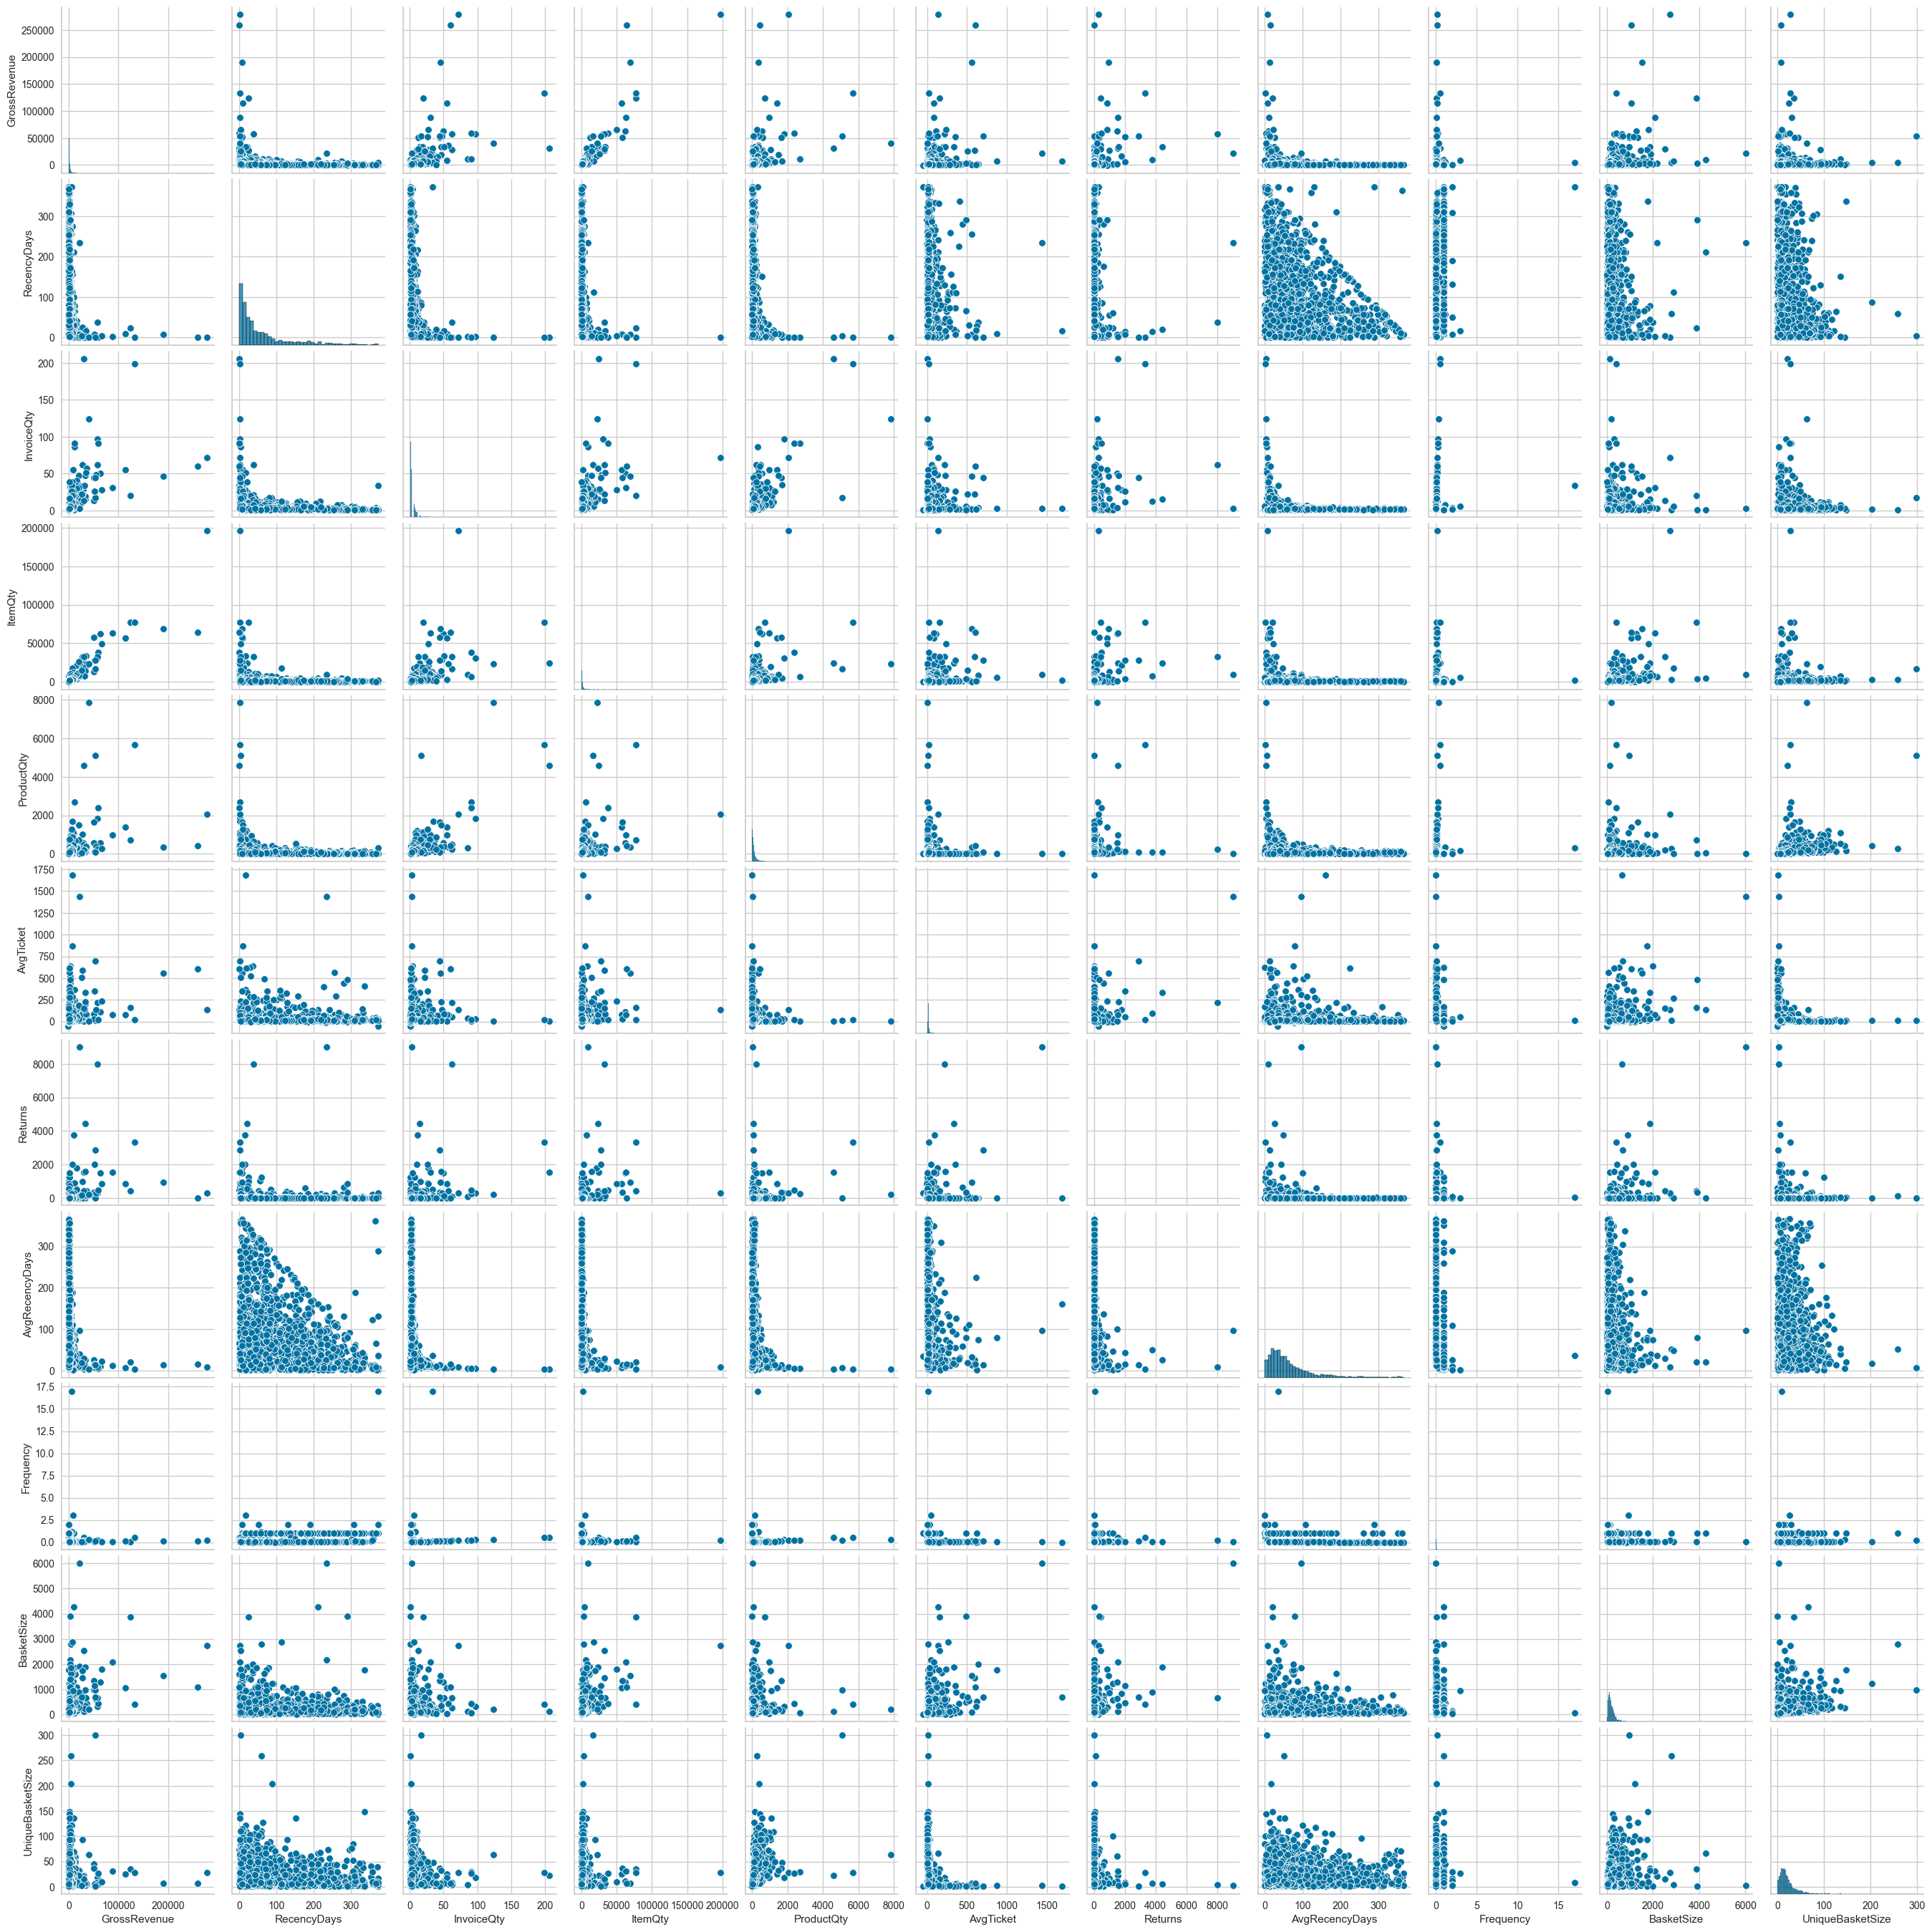

In [42]:
sns.pairplot(df42);

### 4.3 SPATIAL ANALYSIS

In [43]:
df43 = df42.copy()

In [44]:
mm = pp.MinMaxScaler()
df43['GrossRevenue'] = mm.fit_transform(df43[['GrossRevenue']])
df43['RecencyDays'] = mm.fit_transform(df43[['RecencyDays']])
df43['InvoiceQty'] = mm.fit_transform(df43[['InvoiceQty']])
df43['ItemQty'] = mm.fit_transform(df43[['ItemQty']])
df43['AvgTicket'] = mm.fit_transform(df43[['AvgTicket']])
df43['Returns'] = mm.fit_transform(df43[['Returns']])
df43['AvgRecencyDays'] = mm.fit_transform(df43[['AvgRecencyDays']])
df43['Frequency'] = mm.fit_transform(df43[['Frequency']])
df43['BasketSize'] = mm.fit_transform(df43[['BasketSize']])
df43['UniqueBasketSize'] = mm.fit_transform(df43[['UniqueBasketSize']])

X = df43.copy()

#### 4.3.1 PCA

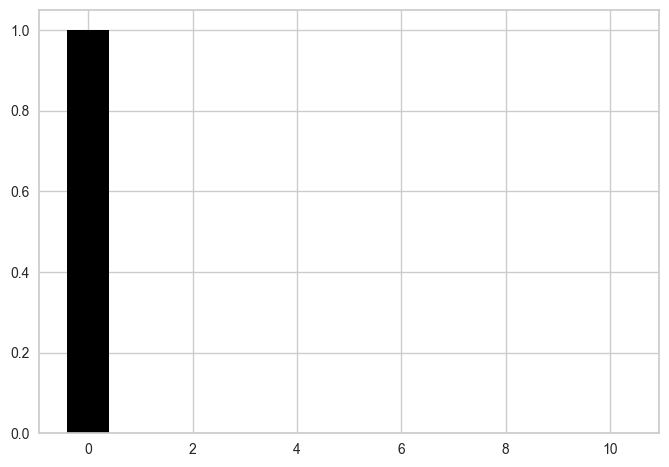

In [45]:
pca = dd.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)
features = range(pca.n_components_)
plt.bar(features,pca.explained_variance_ratio_,color='black')
df_pca = pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

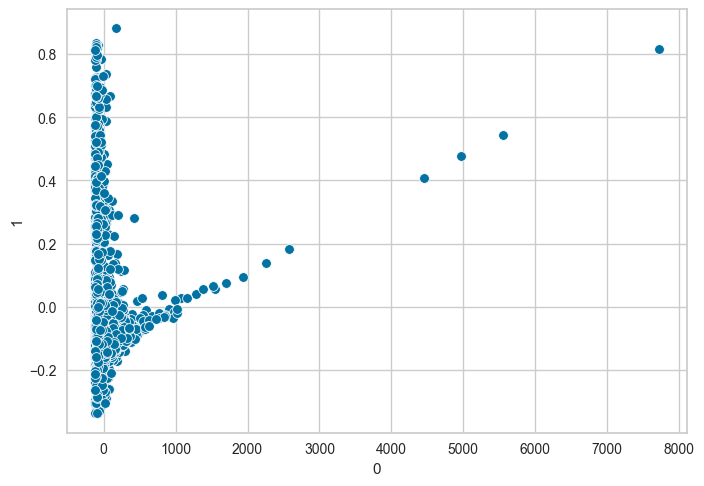

In [46]:
sns.scatterplot(x=0,y=1,data=df_pca)

#### 4.3.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

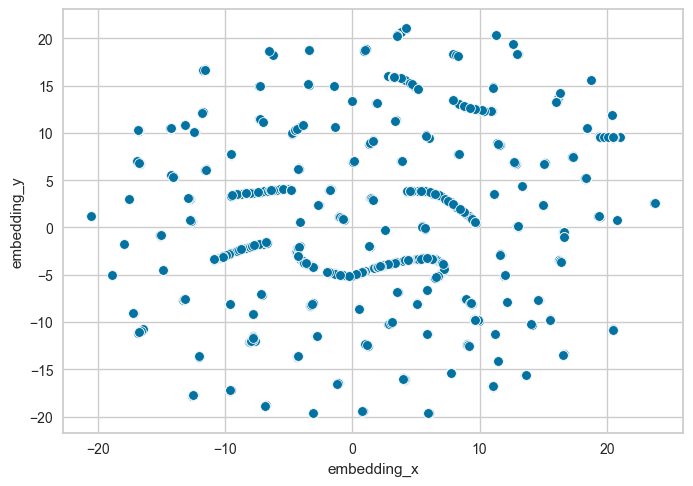

In [47]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

sns.scatterplot(x='embedding_x',y='embedding_y',data=df_pca)

#### 4.3.3 t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

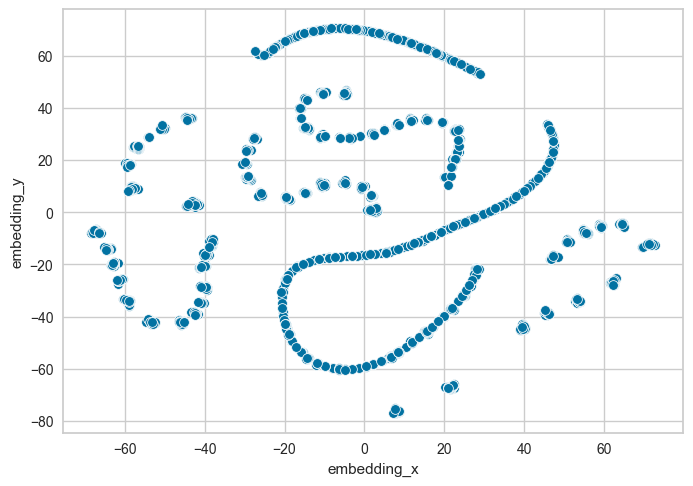

In [48]:
reducer = TSNE(n_components=2,n_jobs=-1,random_state=42)
embedding = reducer.fit_transform(X)
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

sns.scatterplot(x='embedding_x',y='embedding_y',data=df_pca)


#### 4.3.4 TREE BASED EMBEDDING

In [49]:
from sklearn import ensemble as en

In [50]:
X = df4.drop(columns=['CustomerID','GrossRevenue'],axis=1)
y = df4['GrossRevenue']

rf_model = en.RandomForestRegressor(n_estimators=100,random_state=42)
rf_model.fit(X,y)

RandomForestRegressor(random_state=42)

In [51]:
df_leaf = pd.DataFrame(rf_model.apply(X))

In [52]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,3334,3378,3338,3331,3290,3264,3301,3346,3322,3365,3157,3213,3214,3439,3341,3300,3334,3189,3226,3224,3223,3265,3350,3232,3371,3289,3171,3301,3207,3321,3195,3177,3296,3273,3271,3330,3400,3254,3284,3348,3423,3244,3214,3270,3366,3194,3318,3378,3346,3351,3331,3351,3283,3276,3234,3336,3360,3362,3240,3338,3272,3262,3311,3328,3266,3390,3339,3314,3319,3322,3315,3361,3290,3268,3338,3281,3279,3190,3344,3396,3290,3185,3360,3193,3302,3363,3225,3320,3277,3359,3268,3250,3228,3258,3412,3282,3121,3238,3301,3399
1,3285,3013,3111,3350,3203,3287,3261,3082,3176,3326,3131,3069,3145,3262,3205,3232,3209,3101,3184,3166,3190,3109,3321,3065,3407,2991,2954,3276,3212,3123,3002,3199,3062,3220,3281,3230,3354,3074,3185,3300,3304,3477,3151,3283,2987,3069,2872,3428,3349,3314,3296,3120,3339,3285,3112,3134,3060,3213,3051,3068,3070,3276,3208,3273,3182,3193,3293,3166,3192,3274,3274,3319,3147,3198,3252,3369,2979,3224,3254,3047,2911,3036,3275,3054,2993,3291,3267,3143,2848,2954,3232,3133,3156,3220,2690,3289,2717,3098,3335,3354
2,1920,2072,2158,2146,1710,2083,1318,2199,1618,1517,2033,1717,2034,1929,1393,1803,2110,1442,1738,1748,2091,1409,1970,1469,2115,1717,2073,1444,1461,2196,2140,2173,1831,2020,1320,1592,1490,2167,1619,2033,1290,1529,2019,1349,2025,1377,2079,1579,1647,1931,1730,2097,1264,1850,1502,1409,2041,2029,1633,1819,1765,1246,1687,1569,1671,1897,2179,1441,1560,1414,1269,1884,1966,1628,1671,2005,2082,1771,1916,2090,1997,1253,1758,1177,1959,1988,1450,2229,2021,2000,1787,1787,1810,1872,1228,1997,1523,1531,2179,1730
3,2733,3053,2451,3132,2866,2996,2662,2588,2789,3063,2765,3133,2788,2944,2693,2553,2898,2631,2771,2543,2610,2544,2942,2576,2744,2994,2563,2951,2721,2716,2563,2677,2708,2900,2955,2461,2833,2818,2752,2777,2646,2957,2508,2721,2569,2665,2890,2824,2786,2847,2824,2435,2715,3073,2576,2493,2536,2556,2599,2504,2659,2925,2830,2658,2865,2637,2618,2973,2648,2753,2716,2932,2955,3030,2872,2874,2632,2804,2788,2512,2483,2581,2742,2635,2442,2785,2707,2684,3018,2415,2632,2502,2546,2777,2781,2503,2745,2492,2988,3088
4,943,768,1311,637,364,850,878,1337,1001,762,952,506,793,860,1084,403,783,793,743,1367,826,979,883,809,911,1240,827,1188,489,866,886,844,694,916,1254,862,1184,1281,834,1095,1201,553,833,1276,716,1531,1122,1119,552,1020,758,858,1213,1103,1186,1248,1196,1252,1012,1185,789,839,1084,903,774,1172,1042,864,981,1215,836,1189,1158,1169,936,1211,1226,945,1124,602,686,1161,852,1078,743,1162,795,1048,712,1063,787,892,1074,1216,915,1189,521,1093,788,441


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

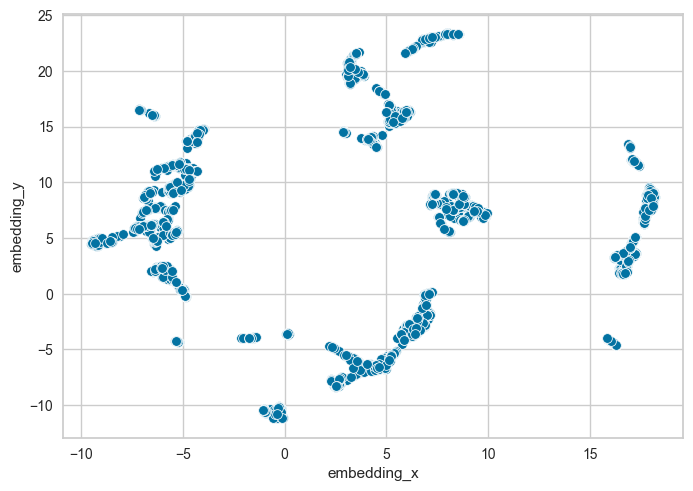

In [53]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

sns.scatterplot(x='embedding_x',y='embedding_y',data=df_pca)

# 5.0 DATA PREPARATION

In [54]:
df5 = df4.copy()

In [55]:
ss = pp.StandardScaler()
df5['GrossRevenue'] = ss.fit_transform(df5[['GrossRevenue']])
df5['RecencyDays'] = ss.fit_transform(df5[['RecencyDays']])
df5['InvoiceQty'] = ss.fit_transform(df5[['InvoiceQty']])
df5['ItemQty'] = ss.fit_transform(df5[['ItemQty']])
df5['ProductQty'] = ss.fit_transform(df5[['ProductQty']])
df5['AvgTicket'] = ss.fit_transform(df5[['AvgTicket']])
df5['Returns'] = ss.fit_transform(df5[['Returns']])
df5['AvgRecencyDays'] = ss.fit_transform(df5[['AvgRecencyDays']])
df5['Frequency'] = ss.fit_transform(df5[['Frequency']])
df5['BasketSize'] = ss.fit_transform(df5[['BasketSize']])
df5['UniqueBasketSize'] = ss.fit_transform(df5[['UniqueBasketSize']])
df5.head()

,CustomerID,GrossRevenue,RecencyDays,InvoiceQty,ItemQty,ProductQty,AvgTicket,Returns,AvgRecencyDays,Frequency,BasketSize,UniqueBasketSize
0,12347,0.170457,-0.801428,0.144034,0.162332,0.219482,-0.072560,-0.123361,-0.101879,-0.232038,0.404763,0.196750
1,12348,-0.118916,0.137505,-0.194709,0.139874,-0.354831,0.376566,-0.123361,0.425724,-0.244389,1.221606,-0.789992
2,12352,-0.136224,-0.364117,0.144034,-0.193243,-0.169569,-0.203528,0.099398,-0.377493,-0.213187,-0.567598,-0.572140
3,12356,-0.013130,-0.544186,-0.307623,0.004596,-0.239968,0.219342,-0.123361,1.326062,-0.254719,1.014920,-0.144979
4,12358,-0.170206,-0.814290,-0.420538,-0.232632,-0.391884,0.397247,-0.123361,1.286689,-0.246230,-0.406041,-0.700288


# 6.0 FEATURE SELECTION

In [56]:
df6 = df5.copy()

# 7.0 HYPERPARAMETER FINE TUNING

In [57]:
X = df6.drop(columns=['CustomerID'])
clusters = [2,3,4,5,6,7]
X.head()

,GrossRevenue,RecencyDays,InvoiceQty,ItemQty,ProductQty,AvgTicket,Returns,AvgRecencyDays,Frequency,BasketSize,UniqueBasketSize
0,0.170457,-0.801428,0.144034,0.162332,0.219482,-0.072560,-0.123361,-0.101879,-0.232038,0.404763,0.196750
1,-0.118916,0.137505,-0.194709,0.139874,-0.354831,0.376566,-0.123361,0.425724,-0.244389,1.221606,-0.789992
2,-0.136224,-0.364117,0.144034,-0.193243,-0.169569,-0.203528,0.099398,-0.377493,-0.213187,-0.567598,-0.572140
3,-0.013130,-0.544186,-0.307623,0.004596,-0.239968,0.219342,-0.123361,1.326062,-0.254719,1.014920,-0.144979
4,-0.170206,-0.814290,-0.420538,-0.232632,-0.391884,0.397247,-0.123361,1.286689,-0.246230,-0.406041,-0.700288


## 7.1 KMEANS

In [58]:
kmeans_list =[]
for k in clusters:
    kmeans_model = c.KMeans(n_clusters=k)
    kmeans_model.fit(X)
    labels = kmeans_model.predict(X)
    sil = m.silhouette_score(X,labels,metric='euclidean')
    kmeans_list.append(sil)

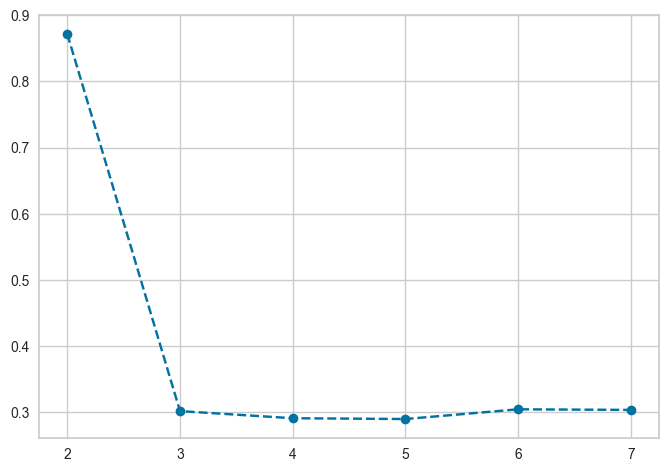

In [59]:
plt.plot(clusters,kmeans_list,linestyle='--',marker='o')

## 7.2 GMM

In [60]:
from sklearn import mixture as mx

In [61]:
gmm_list = []
for k in clusters:
    gmm_model = mx.GaussianMixture(n_components=k)
    gmm_model.fit(X)
    labels = gmm_model.predict(X)
    sil = m.silhouette_score(X,labels,metric='euclidean')
    gmm_list.append(sil)

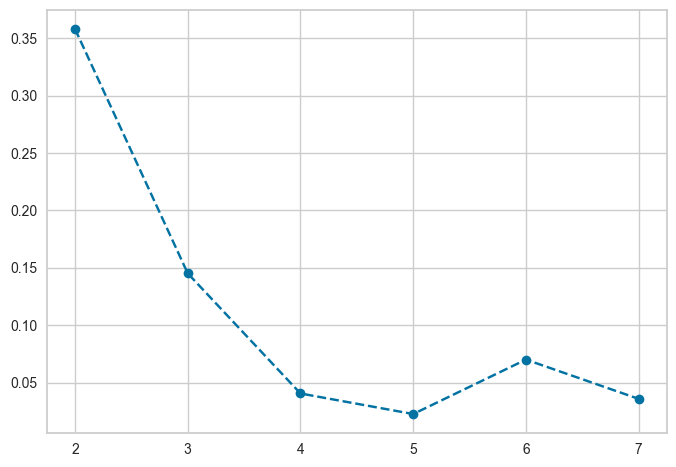

In [62]:
plt.plot(clusters,gmm_list,linestyle='--',marker='o')

## 7.3 HIERARCHICAL CLUSTERING

In [69]:
from scipy.cluster import hierarchy as hc

In [70]:
hc_model = hc.linkage(X,'ward')

[]

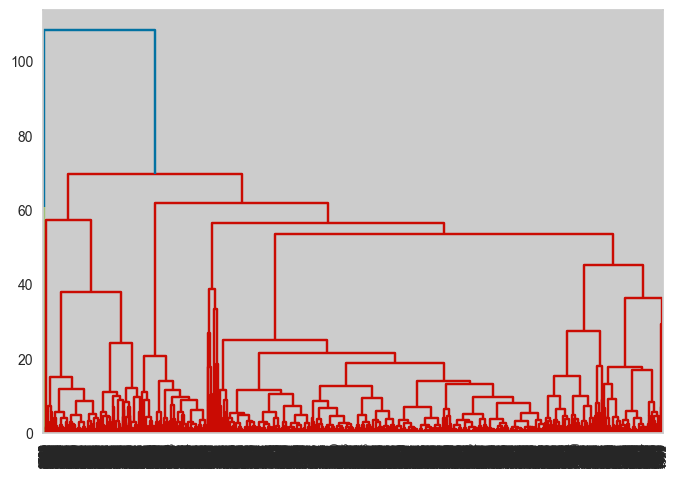

In [72]:
hc.dendrogram(
    hc_model,
    leaf_rotation=90,
    leaf_font_size=8)

plt.plot()

[]

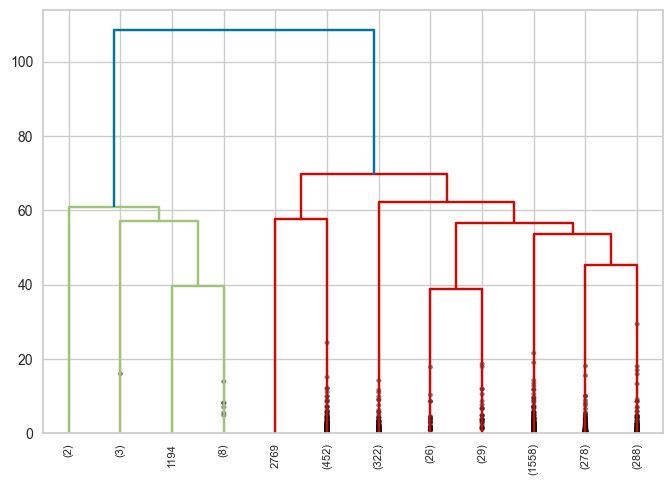

In [73]:
hc.dendrogram(
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90,
    leaf_font_size=8,
    show_contracted=True)

plt.plot()

### 7.3.1 SILHOUETTE SCORE

In [76]:
hc_list = []
for k in clusters:
    hc_model = hc.linkage(X,'ward')
    labels = hc.fcluster(hc_model,k,criterion='maxclust')
    sil = m.silhouette_score(X,labels,metric='euclidean')
    hc_list.append(sil)

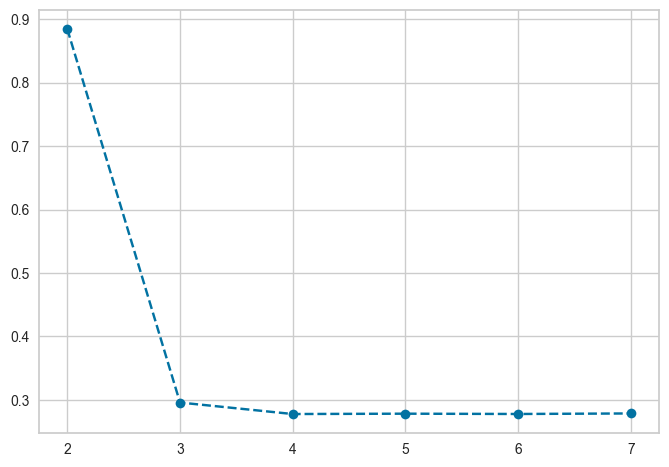

In [77]:
plt.plot(clusters,hc_list,linestyle='--',marker='o')

## 7.4 DBSCAN

In [85]:
eps=1
min_samples=20
dbscan_model = c.DBSCAN(eps=eps,min_samples=min_samples)
labels = dbscan_model.fit_predict(X)
sil = m.silhouette_score(X,labels,metric='euclidean')
sil

0.5281564527252992

In [88]:
from sklearn.neighbors import NearestNeighbors

In [90]:
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, indices = neighbors.kneighbors(X)

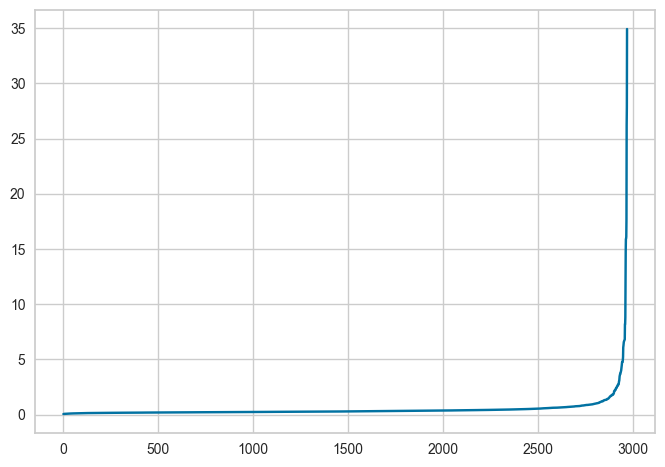

In [91]:
distances = np.sort(distances,axis=0)
distances = distances[:,1]
plt.plot(distances)

## 7.5 RESULTS

In [79]:
df_results = pd.DataFrame(
{'Kmeans': kmeans_list,
'GMM': gmm_list,
'HC':hc_list}).T
df_results.columns = clusters
df_results.style.highlight_max(color='lightgreen',axis=1)

,2,3,4,5,6,7
Kmeans,0.871512,0.302106,0.291336,0.290122,0.304801,0.303887
GMM,0.357938,0.145069,0.040439,0.022542,0.069964,0.035750
HC,0.884521,0.295747,0.277642,0.278183,0.277708,0.278557


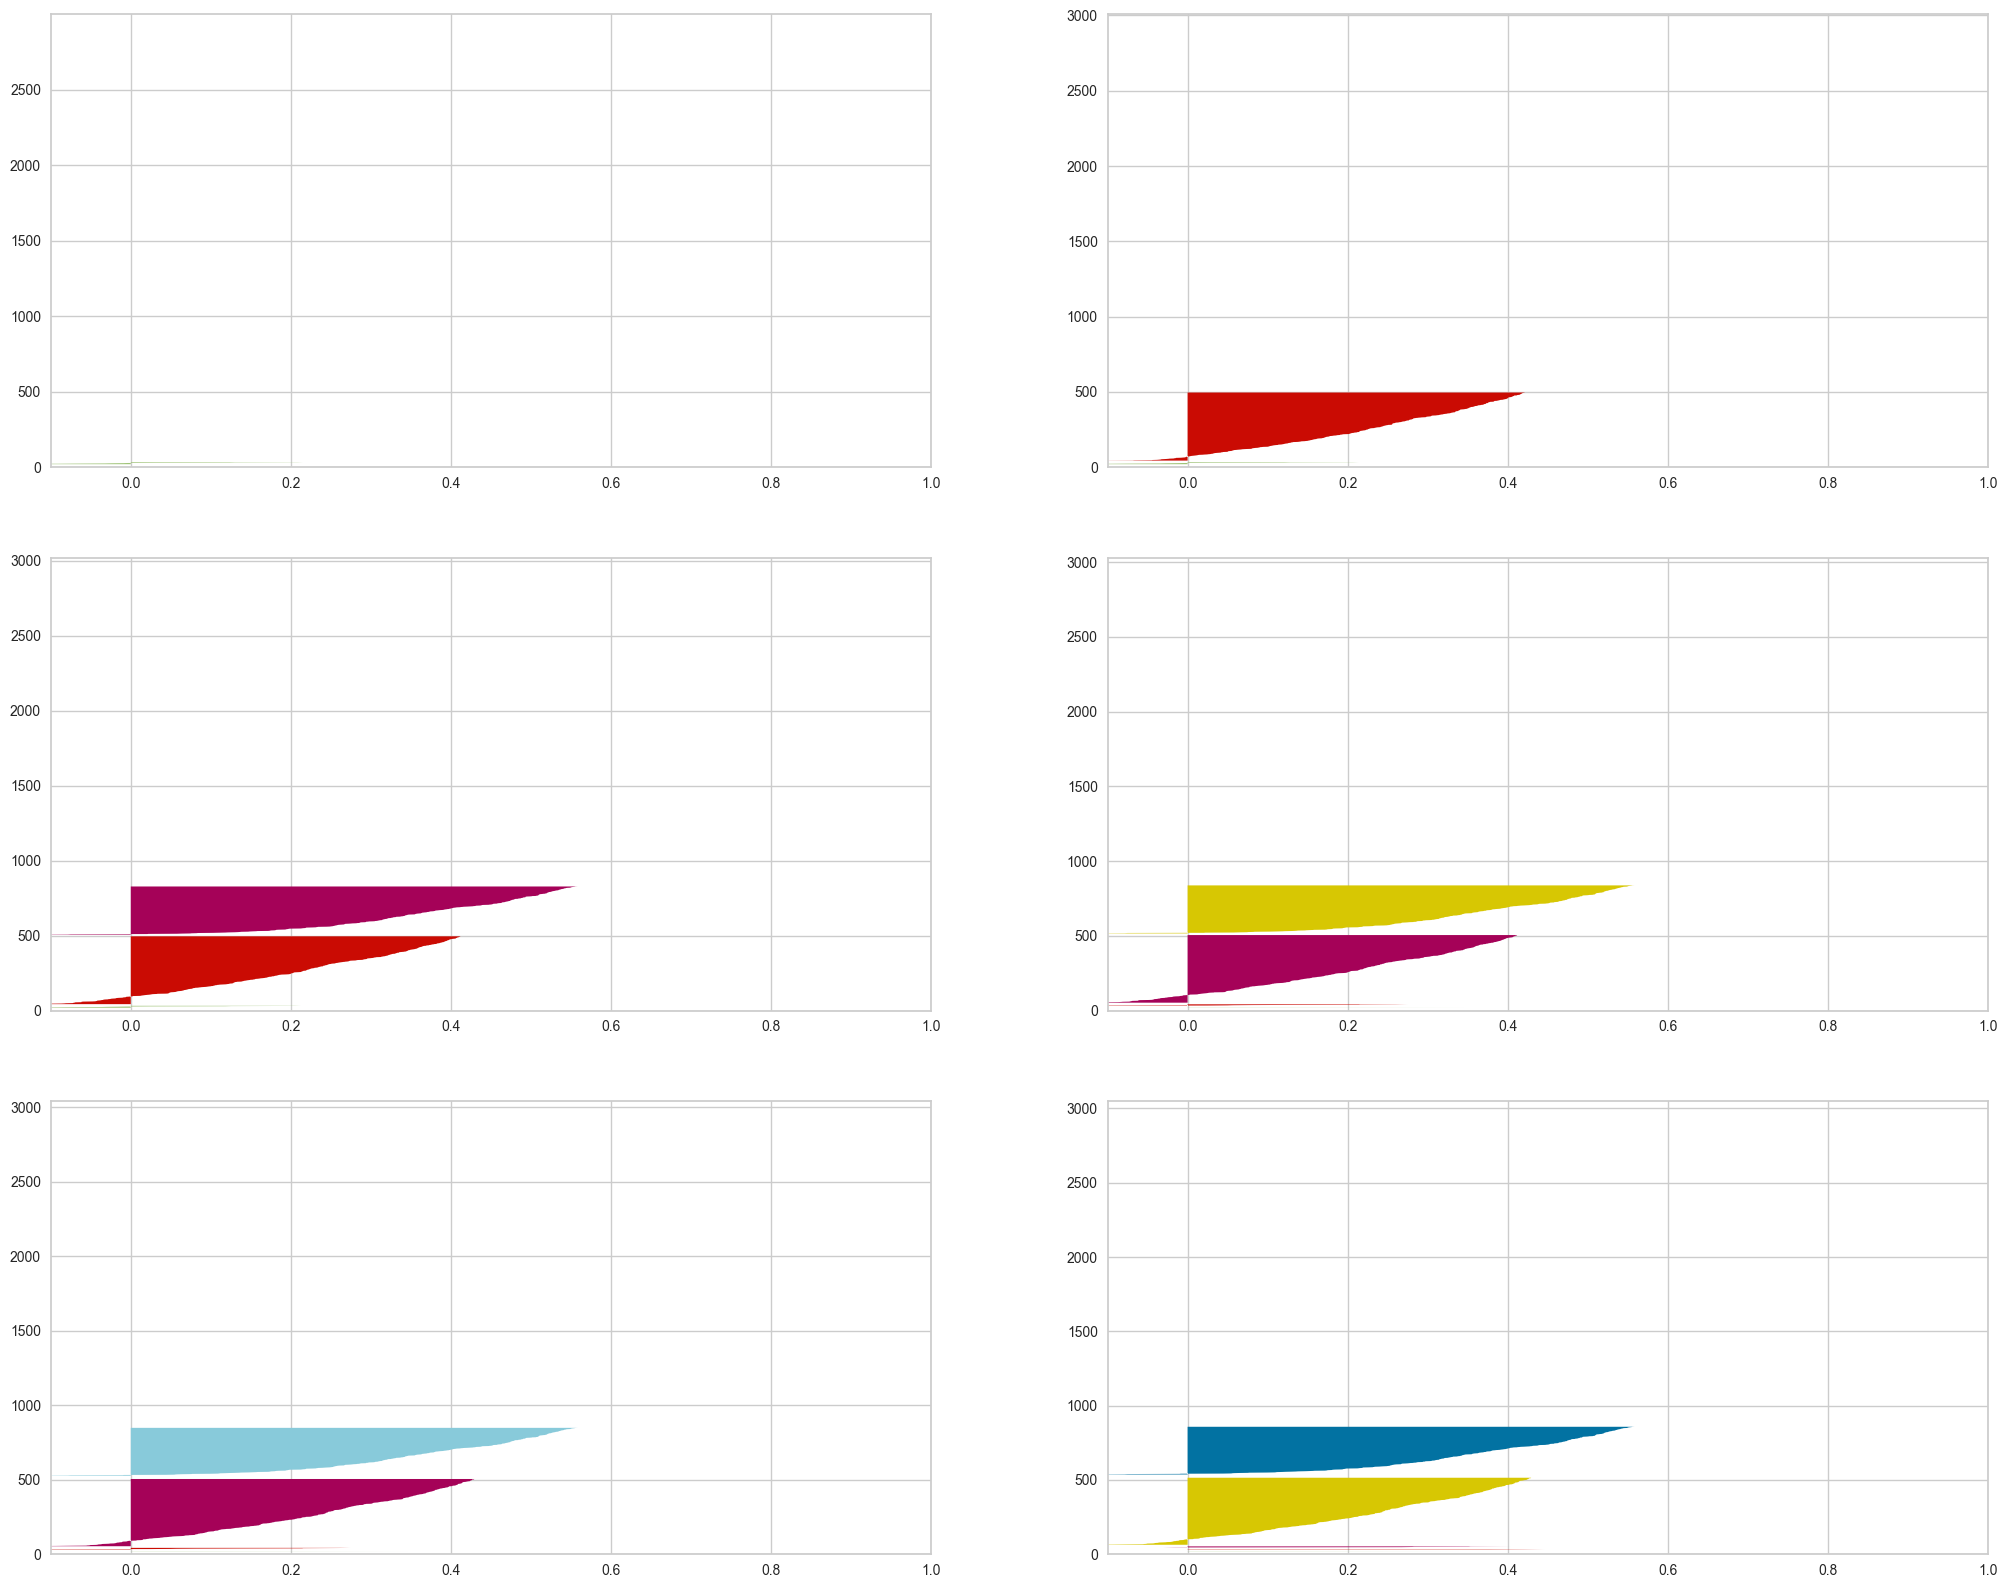

In [95]:
fig,ax = plt.subplots(3,2)
fig.set_size_inches(25,20)

for k in clusters:
    q,mod = divmod(k,2)
    ax[q-1,mod].set_xlim([-0.1,1])
    ax[q-1,mod].set_ylim([0,len(X)+(k+1)*10])
    
    hc_model = hc.linkage(X,'ward')
    labels = hc.fcluster(hc_model,k,criterion='maxclust')
    ss = m.silhouette_score(X,labels,metric='euclidean')
    samples_silhouette_values = m.silhouette_samples(X,labels)
    y_lower = 10
    
    for i in range(k):
        ith_samples_silhouette = samples_silhouette_values[labels==i]
        ith_samples_silhouette.sort()
        size_cluster_i = ith_samples_silhouette.shape[0]
        y_upper = y_lower + size_cluster_i
        ax[q-1,mod].fill_betweenx(np.arange(y_lower,y_upper),0,ith_samples_silhouette)
        y_lower = y_upper +10

## 7.1 WITHIN-CLUSTER SUM OF SQUARES (WSS)

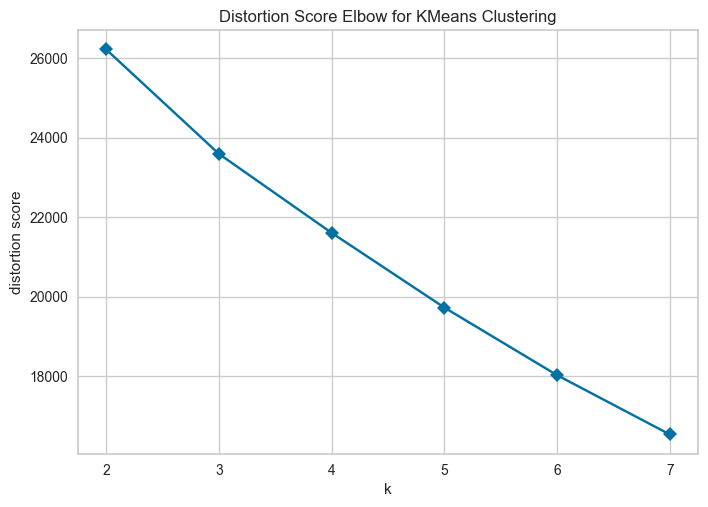

In [64]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters,timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2 SILHOUETTE SCORE

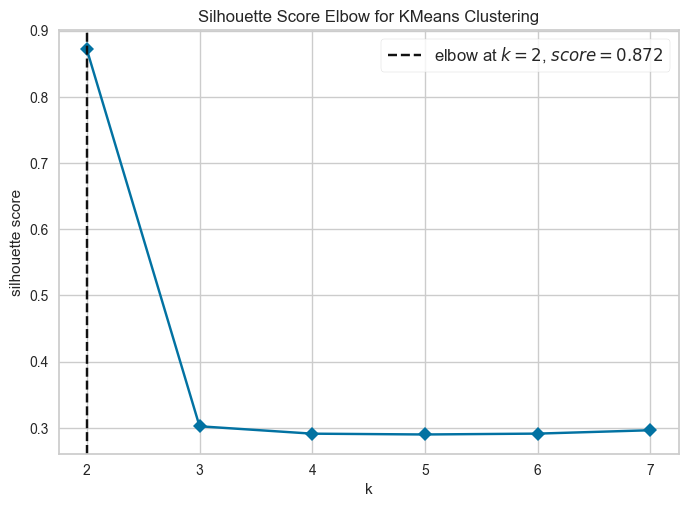

In [65]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters, metric='silhouette',timings=False)
kmeans.fit(X)
kmeans.show();

## 7.3 SILHOUETTE ANALYSIS

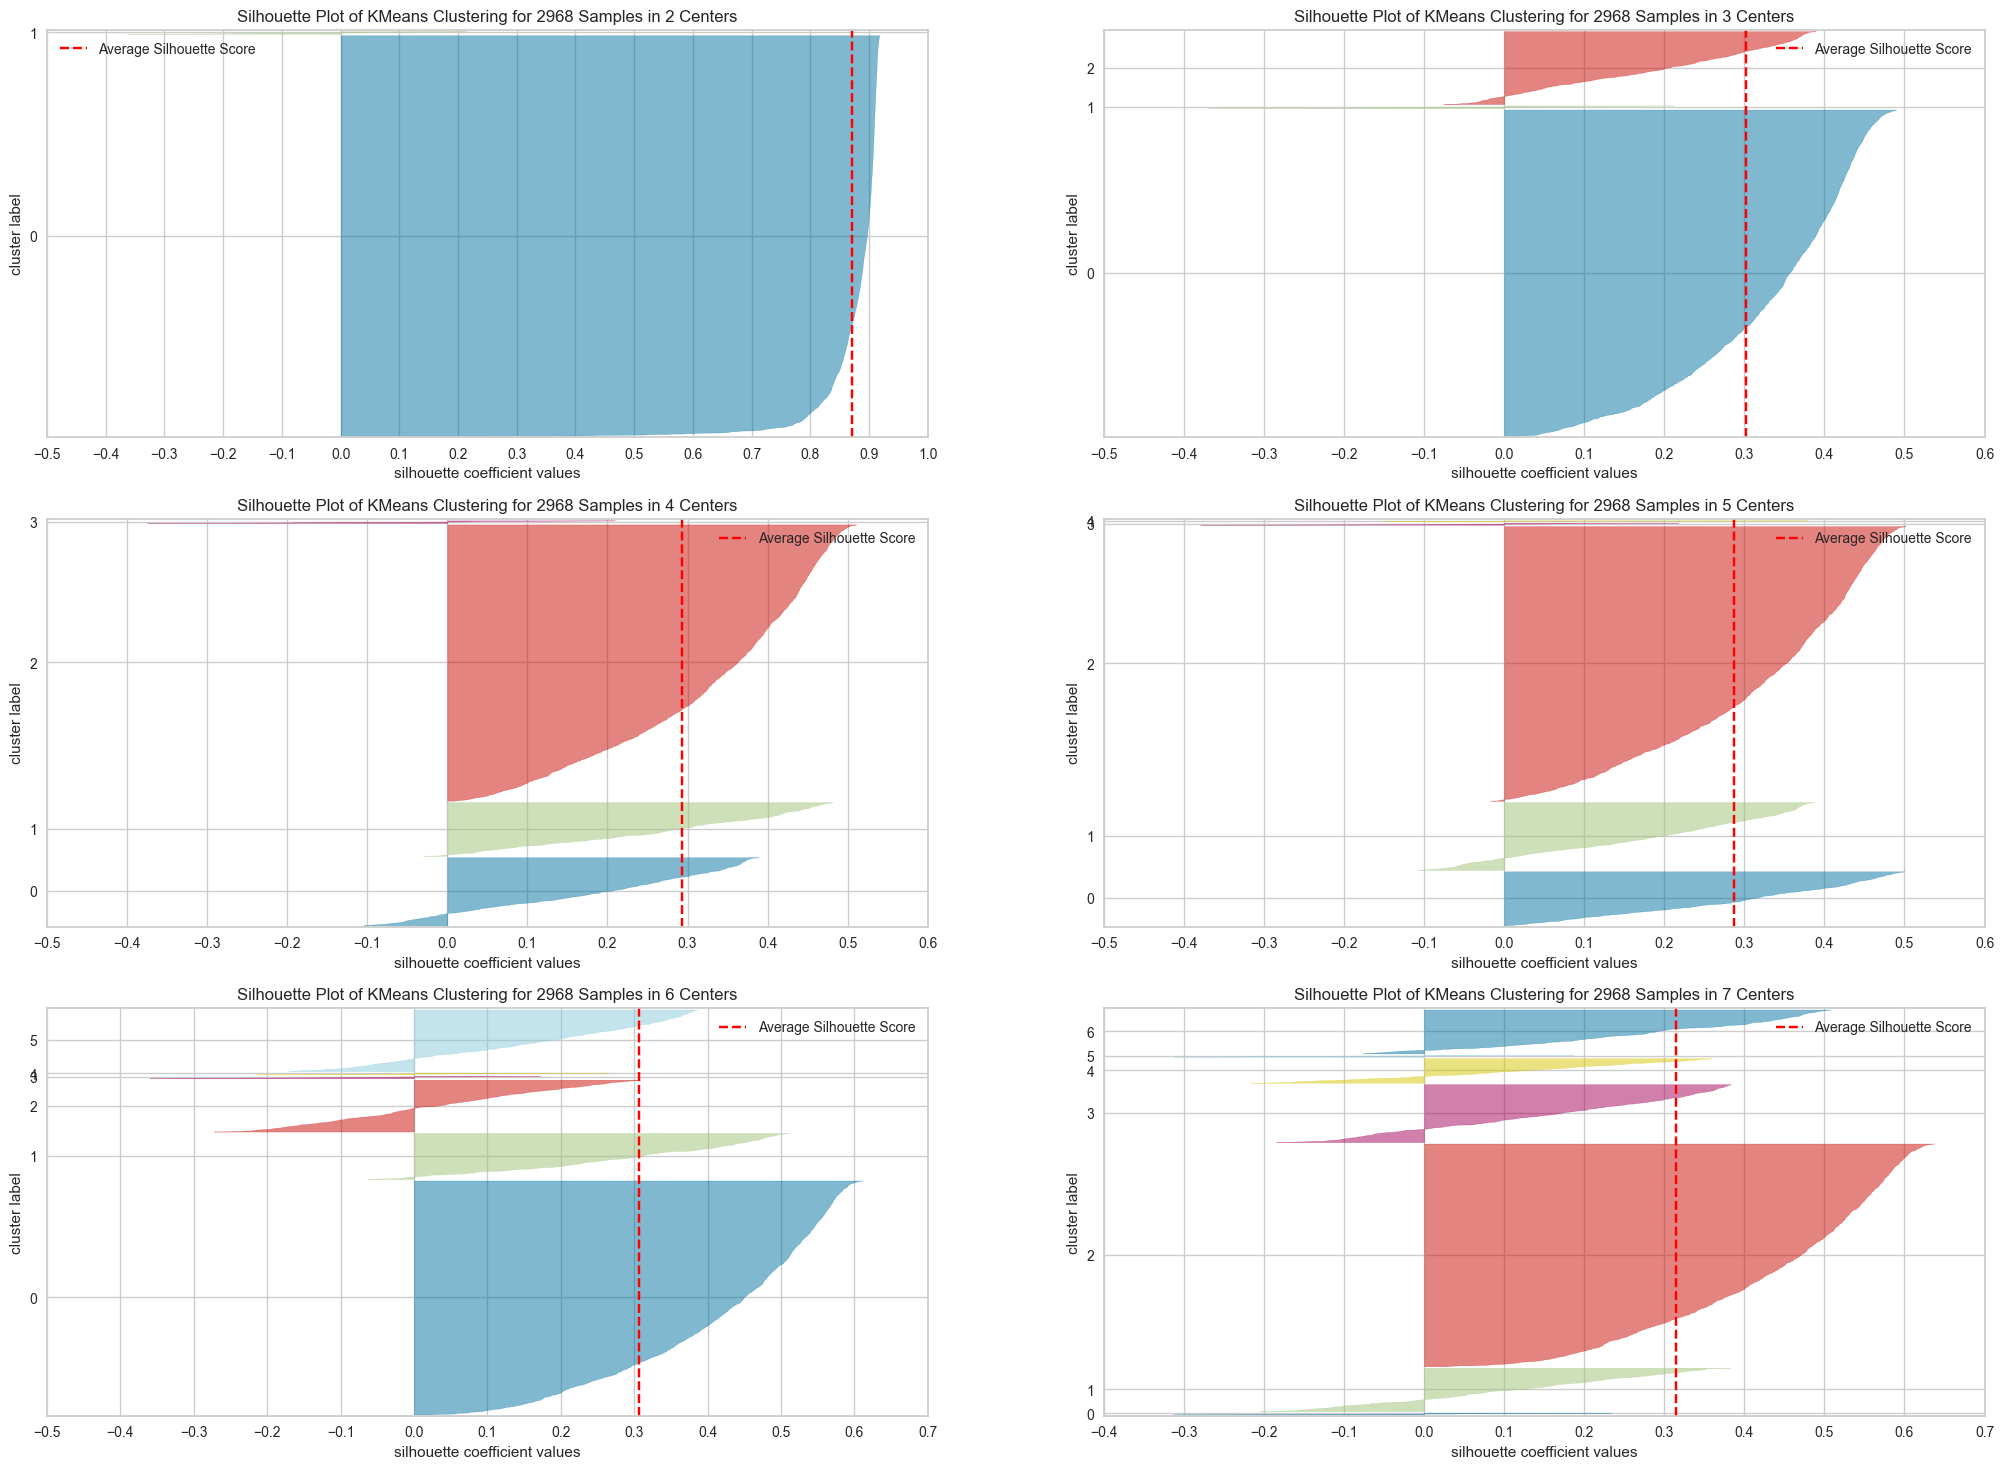

In [66]:
fig,ax = plt.subplots(3,2,figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k,init='random',n_init=10,max_iter=100,random_state=42)
    q, mod = divmod(k,2)    
    visualizer = SilhouetteVisualizer(km,colors='yellowbrick',ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()
    

# 8.0 MODEL TRAINING

In [67]:
k = 4
kmeans = c.KMeans(init='random',n_clusters=k,max_iter=300,random_state=42)
preds = kmeans.fit_predict(X)
labels = kmeans.labels_

In [68]:
print('WSS value:{}'.format(kmeans.inertia_))
print('SS value:{}'.format(met.silhouette_score(X,preds)))

WSS value:21604.897818448284


NameError: name 'met' is not defined

# 9.0 CLUSTER ANALYSIS

In [ ]:
df9 = df4.copy()
df9['cluster'] = labels
df9.head()

## 9.1 VISUALIZATION INSPECTION

In [ ]:
visualizer = SilhouetteVisualizer(kmeans,colors='yellowbrick')
visualizer.fit(X)
visualizer.poof()

## 9.2 2D PLOT

In [ ]:
df_viz = df9.drop(columns=['CustomerID'])
#sns.pairplot(df_viz,hue='cluster');

## 9.3 UMAP

In [ ]:
reducer = umap.UMAP(n_neighbors=20, random_state=42)
embedding = reducer.fit_transform(X)
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

sns.scatterplot(x='embedding_x',y='embedding_y',hue='cluster',palette=sns.color_palette('hls',n_colors=len(df_viz['cluster'].unique())), data=df_viz)


## 9.4 CLUSTER PROFILE

In [ ]:
#Qty per cluster
df_cluster = df9[['CustomerID','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['CustomerID']/df_cluster['CustomerID'].sum())

#Avg gross rev
df_avg_grossrev = df9[['GrossRevenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_grossrev,how='inner',on='cluster')

#Avg recency days
df_avg_rec = df9[['RecencyDays','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_rec,how='inner',on='cluster')

#Avg invoice num
df_avg_invnum = df9[['InvoiceQty','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_invnum,how='inner',on='cluster')

#Avg ticket
df_avg_ticket = df9[['AvgTicket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_ticket,how='inner',on='cluster')

df_cluster.drop(columns=['CustomerID'])